# Federated Learning and Data Distribution

The goal of this notebook is to study the impact of the data distribution between clients when training a model in a distributed fashion.

We will first create the different scenarios of data distributions. Then, we will perform FL on all these scenarios using a small CNN. Finally we will analyse the differences between them and explore solutions to mitigate data heterogeneity.

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("../")

import torch
import random

from utils.tools import plot_example_images, plot_distribution

import numpy as np
import syft as sy
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchmetrics

# Generate the datasets

In [5]:
train_data = datasets.MNIST(root="data", train=True, transform=ToTensor(), download=True)

## Explore Train and Test data

- What is the structure of the datasets `train_data` and `test_data`?
- How many elements is there in the train set? The test set? 
- Can you find the labels? And the images (matrices)?
- What is the shape of an image?

In [4]:
# Separate train labels and features into distinct vectors

"""
Put here your code to explore the data
"""
train_size = pass
test_size = pass
train_labels = pass
train_features = pass
image_shape = pass

assert len(train_labels) == len(train_features) == len(train_data)

## Visualization of MNIST dataset

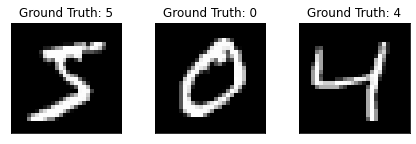

In [5]:
plot_example_images(train_data)

## Data distribution among clients: study of different scenarios

- Case 1: IID and balanced dataset
- Case 2: unbalanced dataset
- Case 3: unbalanced dataset + unbalanced class distribution
- Case 4: extrem asymmetry, no class overlap among clients

In [6]:
n_clients = 3

### Case 1: IID and balanced dataset

First, let's create `n_clients` datasets that are IDD and balanced. This means that all datasets have the same proportion of images of all classes, and that all datasets have the same size.

_Help_: check `random_split` method from pytorch `torch.utils.data`, that randomly split a dataset into non-overlapping new datasets of given lengths. 

In [8]:
def create_balanced_dataset(train_data: Dataset, n_clients: int) -> List[Dataset]:
    """
    TODO
    This function should return a list of training datasets that are balanced
    """
    pass

'\ndef create_balanced_dataset(train_data: Dataset, n_clients: int) -> List[Dataset]:\n    """\n    TODO\n    This function should return a list of training datasets that are balanced\n    """\n    pass\n'

In [9]:
# Create a list of client datasets
balanced_datasets = create_balanced_dataset(train_data, n_clients)

In [ ]:
# Plot distribution
plot_distribution(balanced_datasets)

### Case 2: Unbalanced dataset

Now, let's create `n_clients` datasets that are IDD but unbalanced. This means that all datasets have the same proportion of images of all classes, **but** now some datasets are much bigger or smaller than others.

_Help_: you can reuse `random_split` method with different arguments.

In [11]:
def create_unbalanced_dataset(train_data: Dataset, client_percentages: List[int]):
    """
    TODO
    This function should return a list of training datasets that are unbalanced
    """
    pass

'\ndef create_unbalanced_dataset(train_data: Dataset, client_percentages: List[int]):\n    """\n    TODO\n    This function should return a list of training datasets that are unbalanced\n    """\n    pass\n'

In [ ]:
# Percentage of the MNIST dataset to distribute to each client
client_percentages = [5, 35, 60]

# Create a list of client datasets
unbalanced_datasets = create_unbalanced_dataset(train_data, client_percentages)

print(f"Number of data for client 1 : {len(unbalanced_datasets[0])}")
print(f"Number of data for client {n_clients} : {len(unbalanced_datasets[-1])}")

assert len(unbalanced_datasets[0]) == client_percentages[0] * len(train_data) // 100
assert len(unbalanced_datasets[-1]) == client_percentages[-1] * len(train_data) // 100

In [ ]:
plot_distribution(unbalanced_datasets)

### Case 3: unbalanced class distribution

This time, we'll generate `n_clients` datasets that have unbalanced class distributions: all of them should have the same size **but** not the same class proportions.

To be more precise, as we have 3 workers, you can try to have more `0`s, `1`s and `2`s on the first worker, more `3`s, `4`s, `5`s and `6`s on the second and more `7`s,  `8`s and `9`s on the third. If you do this, when plotting the distributions, you should get something similar to the following graph:

![non iid](images/non-iid-distribution.png "non-iid")

_Help_: 
- Order the data by labels
- Use the `Subset` method from pytorch `torch.utils.data`, to create each client dataset separately.

In [ ]:
def create_noniid_dataset(train_data: Dataset, *args):
    """
    TODO
    This function should return a list of training datasets that are not iid
    """
    pass

In [ ]:
noniid_datasets = create_noniid_dataset(train_data, n_clients, split_nb = 2)

for i in range(n_clients):
    print(f"Number of data for client {i+1} : {len(noniid_datasets[i])}")

In [ ]:
plot_distribution(noniid_datasets)

### Case 4 : extreme asymmetry

Here, we'll try to break FL by creating datasets for which the learning process will be very hard (or will not work at all!). 

We won't give any more information on how to do this, try to use what you've learnt. The only constraints is that each worker should have at least 5000 data sample.

In [ ]:
def create_extreme_dataset(*args):
    """
    TODO
    This function should return a list of training datasets that FL will be very bad at learning on
    """
    pass

In [ ]:
extreme_datasets = create_extreme_dataset(train_data)

In [ ]:
plot_distribution(extreme_datasets)

# Let's train a model on these data

In this part, you'll have to implement a FL training procedure using a basic Federated Averaging algorithm.

This notebook plays the role of the aggregator so the "learning steps" will be done on remote workers. We'll use PySyft's `VirtualMachine` abstraction.

## Quick introduction to PySyft

PySyft is a python library designed to enable manipulation of remote data that you cannot see. You can learn more about it [here](https://github.com/OpenMined/PySyft/tree/syft_0.5.0) (note that we'll use the version 0.5.0 in this notebook).

As we try to understand what happend during federated learning under the hood, we'll only use low-level abstractions and functions of this library.

Basically, the only feature we'll use are:
- Sending local objects to a remote worker: PySyft makes it easy to send almost every object you usually for ML with pytorch. For instance, you can do

```
worker = sy.VirtualMachine(name="worker")

a = torch.Tensor([1, 2, 3])
b = torch.Tensor([4, 5, 6])

ptr_a = a.send(worker)
ptr_b = b.send(worker)
```

- Manipulating data on a remote worker: once you've sent a object to a worker, you get a pointer to this object (try to run the code given just above and print ptr_a). This pointer is designed to make you manipulate the object it points at seemlessly: use it as you would use a local object in any operation:

```
ptr_res = a + b
```
    as the data was remote, what is returned is a pointer to the result.
    
- Retrieving data from a remote worker: you can use the `get` method of a pointer to retrieve the underlying data:

```
local_res = ptr_res.get()
```

### Useful PySyft methods 

- `.send(worker_client)`: you can use this to send an object to another worker. See how it's done in the `# Dispatch data` cell for an example.
- `.get()`: you can use this to retrieve the data a pointer points to.

In [ ]:
# These are the clients that will take part in the federated learning process
alice = sy.VirtualMachine(name="alice")
bob = sy.VirtualMachine(name="bob")
charlie = sy.VirtualMachine(name="charlie")

alice_client = alice.get_root_client()
bob_client = bob.get_root_client()
charlie_client = charlie.get_root_client()

workers = [alice_client, bob_client, charlie_client]

In [32]:
# We won't ask you to design an NN architecture, instead here is the model
# In order to use PySyft, we'll have to use the following wrapper
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 32, 3, 3)
        self.conv2 = self.torch_ref.nn.Conv2d(32, 64, 3, 3)
        self.relu = self.torch_ref.nn.ReLU()
        self.max_pool2d = self.torch_ref.nn.MaxPool2d(2, 1)
        self.flatten = self.torch_ref.nn.Flatten(1)
        self.lin1 = self.torch_ref.nn.Linear(64, 32)
        self.lin2 = self.torch_ref.nn.Linear(32, 10)
        self.log_softmax = self.torch_ref.nn.LogSoftmax(0)

    def forward(self, x):
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.lin1(x))
        x = self.log_softmax(self.lin2(x))
        return x

learning_rate = 0.05

In [33]:
def compute_grads_on_worker(local_model, worker_client, worker_inputs, worker_targets):
    """
    TODO
    
    In this function you'll compute the gradient for a worker.
    To do so:
    - first send the model to the worker using PySyft's functions
    - use the model on the worker's data
    - compute the loss (using worker_client.torch.nn.functional.cross_entropy)
        and apply torch's `backward` method on it
    - get the parameters' gradients and return them: a model has a `.parameters` method that
        returns a list of parameters and each parameter has a `.grad` attribute
    """
    # Send local model to workers
    
    # Use the model on the worker's data

    # Compute loss
    
    # Get gradients
    
    pass

def average_remote_gradients(workers_gradients):
    """
    TODO
    
    In this function you'll compute the mean of the worker gradients.
    To do so:
    - fetch the gradients using PySyft's `get` method.
    - average them (you can use numpy to do so)
    """
    pass

def update_local_model(local_model, opt_local, average_grads):
    """
    TODO
    
    In this function you'll compute the new global model
    To do so:
    - assign the average gradient you computed to the global model
    - use PyTorch's `step()` method on the optimizer
    """
    # Don't forget to zero out the optimizer state
    opt_local.zero_grad()

    pass

In [34]:
# We also provide you with the following evaluation function
def evaluate(model, eval_input, eval_target):
    eval_pred = model(eval_input)
    eval_acc = torchmetrics.functional.accuracy(eval_pred, eval_target)

    return eval_acc

def train(local_model, workers, data_pointers, target_pointers, n_iter, batch_size, len_workers_data):
    workers_gradients = []
    for worker_client, worker_data, worker_targets, len_data in zip(workers, data_pointers, target_pointers, len_workers_data):
        slice_start = (n_iter * batch_size) // len_data
        slice_start = slice_start if slice_start + batch_size < len_data else 0
        workers_gradients.append(
            compute_grads_on_worker(
                local_model,
                worker_client,
                worker_data[slice_start:slice_start+batch_size],
                worker_targets[slice_start:slice_start+batch_size],
            )
        )
        
    # Average gradients locally
    average_grads = average_remote_gradients(workers_gradients)

    # Update local model
    update_local_model(local_model, opt_local, average_grads) 

In [35]:
# Test set 
# Here we keep the test set on the server side, it is the same for all and do not have to be distributed.
# Usually, in Federated Learning, a validation set can be sent with the model to the clients to compute metrics.

eval_data = datasets.MNIST(root="data", train=False, transform=ToTensor())
eval_features, eval_labels = convert_dataset_to_tensors(eval_data)

In [36]:
def dispatch_data(workers, clients_features, clients_labels):
    data_pointers = []
    target_pointers = []
    for worker, client_features, client_labels in zip(workers, clients_features, clients_labels):
        data_pointers.append(client_features.send(worker))
        target_pointers.append(client_labels.send(worker))
        
    return data_pointers, target_pointers

## Case 1: IID and balanced dataset

In [37]:
# And here are the data and labels that each of these clients have on their side.
# Note that in a real case, you wouldn't see them but they would directly come from the client side.

clients_features, clients_labels = convert_datasets_to_tensors(balanced_datasets)
len_workers_data = [len(data) for data in clients_labels]
# Dispatch data
data_pointers, target_pointers = dispatch_data(workers, clients_features, clients_labels)

In [ ]:
batch_size = 256
local_model = SyNet(torch)
opt_local = optim.Adam(params=local_model.parameters(), lr=learning_rate)

for n_iter in range(10):
    train(local_model, workers, data_pointers, target_pointers, n_iter, batch_size, len_workers_data)

    # Compute local loss to monitor training
    if n_iter % 5 == 0:
        eval_acc = evaluate(local_model, eval_features, eval_labels)
        print(eval_acc)

## Case 2: Unbalanced dataset

In [39]:
clients_features, clients_labels = convert_datasets_to_tensors(unbalanced_datasets)
len_workers_data = [len(data) for data in clients_labels]
# Dispatch data
data_pointers, target_pointers = dispatch_data(workers, clients_features, clients_labels)

In [ ]:
batch_size = 256
local_model = SyNet(torch)
opt_local = optim.Adam(params=local_model.parameters(), lr=learning_rate)

for n_iter in range(10):
    train(local_model, workers, data_pointers, target_pointers, n_iter, batch_size, len_workers_data)

    # Compute local loss to monitor training
    if n_iter % 5 == 0:
        eval_acc = evaluate(local_model, eval_features, eval_labels)
        print(eval_acc)

## Case 3: Non-iid dataset

In [41]:
clients_features, clients_labels = convert_datasets_to_tensors(noniid_datasets)
len_workers_data = [len(data) for data in clients_labels]

noniid_dataset_tensors = list(zip(clients_features, clients_labels ))
random.shuffle(noniid_dataset_tensors)
clients_features, clients_labels  = list(zip(*noniid_dataset_tensors))

# Dispatch data
data_pointers, target_pointers = dispatch_data(workers, clients_features, clients_labels)

In [ ]:
batch_size = 256
local_model = SyNet(torch)
opt_local = optim.Adam(params=local_model.parameters(), lr=learning_rate)

for n_iter in range(10):
    train(local_model, workers, data_pointers, target_pointers, n_iter, batch_size, len_workers_data)

    # Compute local loss to monitor training
    if n_iter % 5 == 0:
        eval_acc = evaluate(local_model, eval_features, eval_labels)
        print(eval_acc)

## Case 4: Extreme dataset

In [44]:
clients_features, clients_labels = convert_datasets_to_tensors(extreme_datasets)
len_workers_data = [len(data) for data in clients_labels]
# Dispatch data
data_pointers, target_pointers = dispatch_data(workers, clients_features, clients_labels)

In [ ]:
batch_size = 256
local_model = SyNet(torch)
opt_local = optim.Adam(params=local_model.parameters(), lr=learning_rate)

for n_iter in range(10):
    train(local_model, workers, data_pointers, target_pointers, n_iter, batch_size, len_workers_data)

    # Compute local loss to monitor training
    if n_iter % 5 == 0:
        eval_acc = evaluate(local_model, eval_features, eval_labels)
        print(eval_acc)

* You should have obtained an accuracy around 0.10 (10%), what does it mean?
* Has your model learned anything?

# Analyses

Let's try to summarize what happened in all the experiments we did!

## Final accuracy

The first thing we want to know is how well the final model performs. To do so, print the accuracy of each model (models that have been trained using the different data distribution) and compare them.

What do you think about the results you got? Is it what you expected? Why do you think did this happen?

In [ ]:
"""
TODO
"""

## Convergence rate

Now, we'll try to see how fast these performances were reached. Try to plot a graph 

To do so, you may have to tweak a bit the training functions that are above (to keep track of the evaluation accuracy during the training) and re-train everything... But as we work with toy data, this shoudln't take too long.

What do you think about the results you got? Is it what you expected? Why do you think did this happen?

In [ ]:
"""
TODO
"""

# Compensate non-IID data 

One strategy is to compensate non-IID data by sending a validated dataset from the server to each clients.

_Help_: 
- Put aside a small random subset of `3000` samples from `train_data` that won't be distributed among clients (at first).
- Make sure the small dataset is IID (same number of samples per class).
- Create client datasets on the rest of the `train_data` set (containing `len(train_data) - 3000` samples), following the extrem iid-case.
- Add the kept dataset to each client datasets (check `ConcatDataset` from pytorch `torch.utils.data`).

In [ ]:
def create_compensated_dataset(train_data, n_data_kept, client_percentages):
    """TODO"""
    pass

In [ ]:
n_data_kept = 3000
compensated_datasets = create_compensated_dataset(train_data, n_data_kept, client_percentages)

print(f"Number of data for client 1 : {len(client_datasets[0])}")
print(f"Number of data for client {n_clients} : {len(client_datasets[-1])}")

assert len(compensated_datasets[0]) == (len(train_data)-n_data_kept) * client_percentages[0] // 100 + n_data_kept
assert len(compensated_datasets[-1]) == (len(train_data)-n_data_kept) * client_percentages[-1] // 100 + n_data_kept

In [ ]:
plot_distribution(client_datasets)

## Model training on this compensated dataset

In [ ]:
clients_features, clients_labels = convert_datasets_to_tensors(compensated_datasets)
len_workers_data = [len(data) for data in clients_labels]
# Dispatch data
data_pointers, target_pointers = dispatch_data(workers, clients_features, clients_labels)

In [ ]:
batch_size = 256

for epoch in range(3):
    for n_iter in range(len_worker_data // batch_size):
        train(local_model, workers, data_pointers, target_pointers, n_iter, batch_size)

        # Compute local loss to monitor training
        if n_iter % 20 == 0:
            eval_acc = evaluate(local_model, (eval_features, eval_labels))
            print(eval_acc)

## Other strategies to compensate non-IID data

- What are the drawbacks of the method you have just implemented?
- Can you explain three other ways to compensate non-IID data? _(no code required)_